In [1]:
pip install gensim konlpy

In [2]:
import numpy as np
import pandas as pd
import re
import gensim
import matplotlib.pyplot as plt

from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from konlpy.tag import Okt
from tqdm import tqdm
from gensim import corpora, models
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel


from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.cluster import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
#pip install gensim konlpy

In [5]:
import pickle
with open('/content/drive/My Drive/data/DCX/clustering_result.pkl','rb') as f:
    df = pickle.load(f)

In [6]:
df.head()

,time,review,re_review,review_words,vector,cluster
0,2023. 5. 30. 17:09,나의 가계부 지출 년 월 생활비 정산 만 원 가계부 인 가구 자취 생활비 식비 ...,나의 가계부 지출 년 월 생활비 정산 만 원 가계부 인 가구 자취 생활비 식비 아끼...,"[가계부, 지출, 생활비, 정산, 가계부, 가구, 자취, 생활비, 식비, 고정, 지...","[0.91891223, -0.62368906, 0.6758929, -0.678698...",2
1,2022. 10. 9. 22:41,신혼부부가계부 신혼부부 가계부화목 화목 신혼부부 가계부입당 화연휴 끝나고 오랜만에 ...,신혼부부가계부 신혼부부 가계부화목 화목 신혼부부 가계부입당 화연휴 끝나고 오랜만에 ...,"[신혼부부, 가계부, 신혼부부, 가계부, 화목, 화목, 신혼부부, 가계부, 입당, ...","[-0.2629604, -0.5717506, 1.1107559, 0.5296085,...",2
2,2022. 7. 2. 4:34,예금의 진실 문득 투자를 하고 경제의 흐름을 알아가니왜 예금을 했었나난 단지 ...,예금의 진실 문득 투자를 하고 경제의 흐름을 알아가니왜 예금을 했었나난 단지 안정...,"[예금, 진실, 문득, 투자, 경제, 흐름, 예금, 안정, 이자, 적금, 투자, 예...","[0.08295519, 0.24779752, 0.32473674, -0.340607...",1
3,2022. 7. 6. 5:19,카카오뱅크 청년전세자금대출 연장 년 금리변동 카카오뱅크 청년전세자금대출 서류금리...,카카오뱅크 청년전세자금대출 연장 년 금리변동 카카오뱅크 청년전세자금대출 서류금리승...,"[카카오, 뱅크, 청년, 전세, 자금, 대출, 연장, 금리, 변동, 카카오, 뱅크,...","[-0.7301975, -0.59152293, 1.864779, 0.3563278,...",2
4,2022. 8. 15. 18:08,우당탕탕 다신 안가고싶은 삼성병원 가지베이컨그라탕해먹기 미친 폭우랑 전쟁하기 ...,우당탕탕 다신 안가고싶은 삼성병원 가지베이컨그라탕해먹기 미친 폭우랑 전쟁하기 급 ...,"[삼성, 병원, 가지, 베이컨, 그라탕, 먹기, 미치다, 폭우, 전쟁, 양양, 아버...","[-0.0634802, -0.074111454, 0.5433737, 0.691810...",1


In [7]:
df_cluster2 = df[df['cluster'] ==  2]

In [8]:
all_documents = list(df_cluster2['review_words'])
dictionary = corpora.Dictionary(all_documents)
dictionary.filter_extremes(no_below=3, no_above=0.8)
corpus = [dictionary.doc2bow(doc) for doc in all_documents]

## LDA

In [9]:
topic_num = 3

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = topic_num, id2word = dictionary, passes = 20, iterations= 50, random_state= 42)

In [10]:
ldamodel.print_topics(num_words = 5)

[(0, '0.015*"적금" + 0.013*"없다" + 0.013*"만원" + 0.011*"생각" + 0.010*"통장"'),
 (1, '0.035*"지출" + 0.018*"가계부" + 0.012*"소비" + 0.011*"없다" + 0.009*"생각"'),
 (2, '0.014*"테크" + 0.012*"포인트" + 0.010*"생각" + 0.009*"투자" + 0.008*"가계부"')]

In [11]:
perplexity_score = ldamodel.log_perplexity(corpus)
perplexity_score

-7.092391677102114

In [12]:
top_n = 3
coherence_model = CoherenceModel(model=ldamodel, texts= all_documents, dictionary=dictionary, topn = top_n)
coherence_score = coherence_model.get_coherence()
coherence_score

0.6934349864832038

# Perplexity 그래프

In [13]:
perplexity_values = []

for i in range(2,10):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word = dictionary)
    perplexity_v = ldamodel.log_perplexity(corpus)
    perplexity_values.append(perplexity_v)

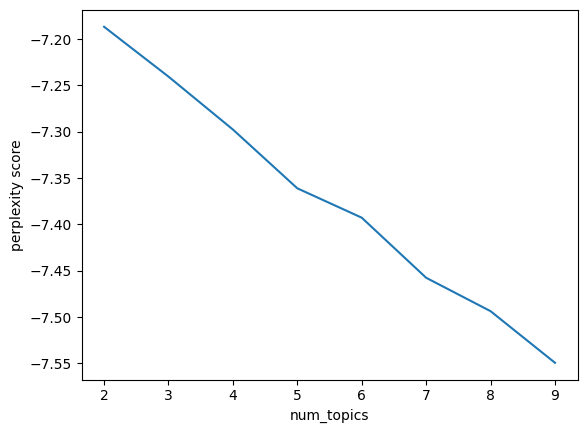

In [14]:
x = range(2,10)
plt.plot(x, perplexity_values)
plt.xlabel('num_topics')
plt.ylabel('perplexity score')
plt.show()

In [15]:
cohernce_values = []
top_n = 3

for i in tqdm(range(2,10)):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word = dictionary)

    coherence_model = CoherenceModel(model=ldamodel, texts= all_documents, dictionary=dictionary, topn = top_n)
    coherence_v = coherence_model.get_coherence()
    cohernce_values.append(coherence_v)

100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


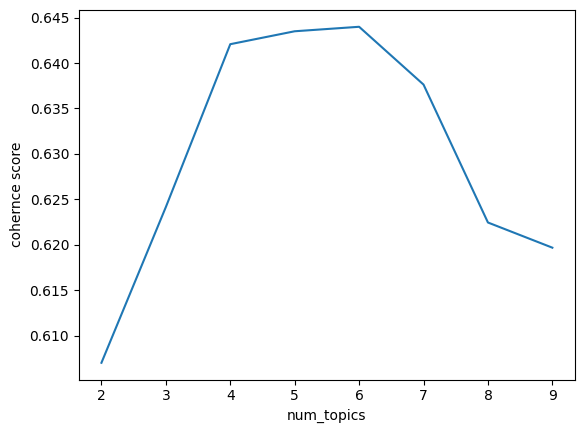

In [16]:
x = range(2,10)
plt.plot(x, cohernce_values)
plt.xlabel('num_topics')
plt.ylabel('cohernce score')
plt.show()

In [17]:
topic_num = 4

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = topic_num, id2word = dictionary, passes = 20, iterations= 50, random_state= 42)

In [18]:
action_align = []

for doc in tqdm(ldamodel.get_document_topics(corpus)):
    label = []
    value = []

    for score in doc:
        label.append(score[0])
        value.append(score[1])

    max_index = np.argmax(value)
    action_align.append(label[max_index])

100%|██████████| 333/333 [00:00<00:00, 2177.45it/s]


In [19]:
df_cluster2['action_cluster'] = action_align
df_cluster2

/tmp/ipython-input-2390297018.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster2['action_cluster'] = action_align


,time,review,re_review,review_words,vector,cluster,action_cluster
0,2023. 5. 30. 17:09,나의 가계부 지출 년 월 생활비 정산 만 원 가계부 인 가구 자취 생활비 식비 ...,나의 가계부 지출 년 월 생활비 정산 만 원 가계부 인 가구 자취 생활비 식비 아끼...,"[가계부, 지출, 생활비, 정산, 가계부, 가구, 자취, 생활비, 식비, 고정, 지...","[0.91891223, -0.62368906, 0.6758929, -0.678698...",2,3
1,2022. 10. 9. 22:41,신혼부부가계부 신혼부부 가계부화목 화목 신혼부부 가계부입당 화연휴 끝나고 오랜만에 ...,신혼부부가계부 신혼부부 가계부화목 화목 신혼부부 가계부입당 화연휴 끝나고 오랜만에 ...,"[신혼부부, 가계부, 신혼부부, 가계부, 화목, 화목, 신혼부부, 가계부, 입당, ...","[-0.2629604, -0.5717506, 1.1107559, 0.5296085,...",2,3
3,2022. 7. 6. 5:19,카카오뱅크 청년전세자금대출 연장 년 금리변동 카카오뱅크 청년전세자금대출 서류금리...,카카오뱅크 청년전세자금대출 연장 년 금리변동 카카오뱅크 청년전세자금대출 서류금리승...,"[카카오, 뱅크, 청년, 전세, 자금, 대출, 연장, 금리, 변동, 카카오, 뱅크,...","[-0.7301975, -0.59152293, 1.864779, 0.3563278,...",2,3
5,2022. 9. 24. 15:01,직장인은 잠을 줄여야 한다 갓생살기 갓생살기 미라클 모닝시에 일어나 공복에 애플...,직장인은 잠을 줄여야 한다 갓생살기 갓생살기 미라클 모닝시에 일어나 공복에 애플 ...,"[직장인, 살기, 살기, 미라클, 모닝, 공복, 애플, 사이다, 식초, 콜라겐, 카...","[-0.5719875, -0.6866182, 1.7736851, -0.9089017...",2,2
11,2023. 2. 27. 0:54,가계부 월 가계부 언박싱 인가구 대 직장인 식비 만원 지출 원부수입 원 가계부 대 ...,가계부 월 가계부 언박싱 인가구 대 직장인 식비 만원 지출 원부수입 원 가계부 대 ...,"[가계부, 가계부, 언박싱, 가구, 직장인, 식비, 만원, 지출, 부수입, 가계부,...","[0.56985563, -1.7587187, -1.0308654, -1.658835...",2,3
...,...,...,...,...,...,...,...
1007,2022. 7. 9. 23:27,앱테크진행중 앱테크 부수입 꼭 해야하는 스타벅스 문화상품권 전원증정 근데 하나는 ...,앱테크진행중 앱테크 부수입 꼭 해야하는 스타벅스 문화상품권 전원증정 근데 하나는 조...,"[테크, 진행중, 테크, 부수입, 스타벅스, 문화, 상품권, 전원, 증정, 까다롭다...","[0.17533131, -0.57090586, 1.0097554, -1.619967...",2,1
1014,2022. 10. 11. 11:05,스물셋 으로 보는 월의 첫주 밸런스프렌즈 토글 리더스 나한테 많은 영감을 주는 쯔지...,스물셋 으로 보는 월의 첫주 밸런스프렌즈 토글 리더스 나한테 많은 영감을 주는 쯔지...,"[스물, 밸런스, 프렌즈, 토글, 리더, 많다, 영감, 지언, 보고, 다방면, 여러...","[-2.3632855, -1.2914432, -1.4184966, -1.111231...",2,2
1015,2023. 2. 5. 22:20,직장인 갓생 탤이의 갓생 겨울방학 끝 동분서주 바쁜 탤이 공주놀이 넘 즐거워 모...,직장인 갓생 탤이의 갓생 겨울방학 끝 동분서주 바쁜 탤이 공주놀이 넘 즐거워 모든 ...,"[직장인, 탤이, 겨울방학, 동분서주, 바쁘다, 공주, 즐겁다, 모든, 포지션, 최...","[0.035588667, -1.5383601, 0.12325775, -0.12539...",2,2
1016,2023. 4. 3. 14:11,청년전세임대주택 청약 일정 신청 서울특별시 순위로 청약 신청 위치한국토지주택공사...,청년전세임대주택 청약 일정 신청 서울특별시 순위로 청약 신청 위치한국토지주택공사 ...,"[청년, 전세, 임대주택, 청약, 일정, 신청, 서울특별시, 순위, 청약, 신청, ...","[-0.17215164, 0.86128193, -0.3034307, 0.735444...",2,2


In [20]:
df_cluster2['action_cluster'].value_counts()

,count
action_cluster,
3,119
2,91
0,77
1,46


In [21]:
pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 7.3 MB/s eta 0:00:00


In [22]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [23]:
prepared_data = gensimvis.prepare(ldamodel, corpus, dictionary)
pyLDAvis.save_html(prepared_data, 'mini_lda_cluster2.html')
pyLDAvis.display(prepared_data)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [24]:
topics = ldamodel.show_topics(num_words = 10, formatted=True)


for id , topic_desc in topics:
    print(f'topic id : {id}, description : {topic_desc}')

topic id : 0, description : 0.021*"적금" + 0.013*"없다" + 0.013*"만원" + 0.011*"뱅크" + 0.011*"통장" + 0.010*"생각" + 0.009*"좋다" + 0.008*"아니다" + 0.007*"이자" + 0.007*"계좌"
topic id : 1, description : 0.012*"좋다" + 0.010*"없다" + 0.010*"사용" + 0.010*"친구" + 0.009*"생각" + 0.008*"카페" + 0.008*"구매" + 0.008*"카드" + 0.007*"교통카드" + 0.007*"할인"
topic id : 2, description : 0.013*"포인트" + 0.012*"생각" + 0.011*"테크" + 0.009*"좋다" + 0.008*"시작" + 0.007*"없다" + 0.007*"많다" + 0.007*"투자" + 0.006*"공부" + 0.006*"아니다"
topic id : 3, description : 0.043*"지출" + 0.022*"가계부" + 0.018*"소비" + 0.017*"만원" + 0.012*"없다" + 0.010*"생각" + 0.009*"생활비" + 0.008*"식비" + 0.008*"비용" + 0.007*"예산"


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [25]:
#lda 결과랑 클러스터 이름 맞추기
new_action_topic = []

for i in tqdm(df_cluster2.action_cluster):
    if i == 0:
        n = 1
    elif i == 1 :
        n = 2
    elif i == 2 :
        n = 3
    else :
        n = 4

    new_action_topic.append(n)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [26]:
df_cluster2.action_cluster = new_action_topic

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [27]:
df_cluster2['action_cluster'].value_counts()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

,count
action_cluster,
4,119
3,91
1,77
2,46


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [28]:
df_cluster2_ext = df_cluster2[['review','review_words','cluster','action_cluster']]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [29]:
#저장

with open('/content/drive/My Drive/data/DCX/미니프로젝트/Cluster2.pkl', "wb") as f:
    pickle.dump(df_cluster2_ext, f)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [30]:
#저장
df_cluster2_ext.to_csv('/content/drive/My Drive/data/DCX/미니프로젝트/Cluster2.csv', encoding='utf-8-sig', index = False)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [31]:
df_cluster2_ext[df_cluster2_ext['action_cluster']== 1]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

,review,review_words,cluster,action_cluster
24,식비절약 가계부 인가족 한달식비 만원 식비절약밥상 일 일째 맞벌이 부부 밥상 직장인...,"[식비, 절약, 가계부, 가족, 식비, 만원, 식비, 절약, 밥상, 맞벌이, 부부,...",2,1
33,경제일지 직장인의 평범한 재테크 토스뱅크 카카오뱅크 주식투자 등 직장인이 되고나서...,"[경제, 일지, 직장인, 평범하다, 재테크, 토스, 뱅크, 카카오, 뱅크, 주식, ...",2,1
65,금융 케이뱅크 선착순 코드 자유적금 고금리적금추천 하이 나쥬디오랜만에 고금리 적금 ...,"[금융, 케이, 뱅크, 선착순, 코드, 자유적금, 금리, 적금, 추천, 하이, 쥬디...",2,1
68,조금 우울하다 연휴 생겨 신난 의 간만에 와플대학 딸기 와플생딸기와플 집에서...,"[우울하다, 연휴, 신나다, 간만, 와플, 대학, 딸기, 와플, 딸기, 와플, 와플...",2,1
76,금융 대 직장인 재테크 차곡 돈 모으기 매달 저축를 작성하기로 했다일단 나는 매일 ...,"[금융, 직장인, 재테크, 차곡, 매달, 저축, 작성, 매일, 가계부, 작성, 노션...",2,1
...,...,...,...,...
920,사소한 생각 낰낰 의 나도 내가 이렇게 이틀연속으로 올지 몰랐지롱근데 묘하게 쓰...,"[사소하다, 생각, 낰낰, 이틀, 연속, 재미, 있슴요왜, 냐묜, 기분, 좋아하다,...",2,1
926,일주일 월째주월째주 새로운 도전 한달만에 돌아온 요천입니다약 한달간 회사일도 많았...,"[일주일, 새롭다, 도전, 요천, 회사, 일도, 많다, 회사, 실험실, 안전, 업무...",2,1
974,뒤늦은 기 애플워치 링채우기 완벽한달 만보걷기 적금 랩노쉬 단백질 쿠키 한발짝 늦...,"[뒤늦다, 애플, 워치, 완벽하다, 걷기, 적금, 랩노쉬, 단백질, 쿠키, 발짝, ...",2,1
984,월 둘째주 심심한 자유 월 둘째주 시작해요라서 편한말로 적어요 년 토요일...,"[심심하다, 자유, 시작, 라서, 편하다, 토요일, 처가, 결혼식, 오전, 분주하다...",2,1


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag